# **Multilingual Binary TOLD Classifier - Frozen Layers**
Montag, 21/08/23 16:39

*Based on Chris McCormick, Nick Ryan, Chollet and HuggingFace WiKi and others



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers

We need to identify the GPU device because later on we will load data on to the device.

In [3]:
import torch

# It there's a GPU available...
if torch.cuda.is_available():

  # Tell PyTorch to use the GPU.
  device = torch.device("cuda")

  print('There are %d GPU(s) available.' % torch.cuda.device_count())

  print('We will use the GPU:' , torch.cuda.get_device_name(0))

# If not
else:
  print('No GPU is available, using CPU instead.')
  device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: NVIDIA L4


## **1. Install the Hugging Face library**

*   Transformers package
*   List item



# **2. Load the English ISB Dataset**

Here I'll load the Large English Dataset

## **2.1 Download, Extract & Trim**

In [4]:
import pandas as pd

# Load the dataset into a pandas dataframe.

df_test = pd.read_csv("/content/drive/MyDrive/data/multilingual/allDataCELF.csv",  keep_default_na=False, sep = ";")

## **2.2 Parse**

In the file explorer we can see that both the raw and the tokenized version are available.

We cannot use the version that is already tonkinized and must thus use the tonnkinzer provided by the model to tokinize the raw data -

We'll use Pandas to parse the 'in-domain' training:

let's check out the properties and some data points

We actually only care about two properties - sentence and label, which ascribes a "0" for unacceptable and "1" for accepable.  

In [5]:
df_test.loc[df_test.TOLD_SCORING ==0].sample(5)[['RESPONSE','CELF_SCORING','TOLD_SCORING']]

,RESPONSE,CELF_SCORING,TOLD_SCORING
0,They are eating the banana in the park.,2,0
2781,αδειάζω,0,0
306,… policeman has been looking at us.,2,0
2816,ο τουρίστας ξέχασε τον οδηγό των [Χ] στο σπίτι,2,0
2512,οι επιβοί άφησαν στην επόμενη στάση,0,0


Next we can extract thee sentences and labels of our training set as numpy ndarrays.

In [6]:
responses = df_test.RESPONSE.values
scores = df_test.TOLD_SCORING.values

In [7]:
PATH = "/content/drive/MyDrive/data/mBERT"

In [8]:
from transformers import BertTokenizer

# Load the tokenizer
print('Loading the mBERT Tokenizer')

tokenizer = BertTokenizer.from_pretrained(PATH, do_lower_case=True)

Loading the mBERT Tokenizer


Lets see how the output looks like as we apply it to one sentence

In [9]:
# print original response
print('Original: ', responses[32])

# print original response split into tokens
print('Tokenized: ', tokenizer.tokenize(responses[32]))

# print original response mapped to token ids
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(responses[0])))

Original:  He was kicked by the leg by the donkey.
Tokenized:  ['he', 'was', 'kick', '##ed', 'by', 'the', 'leg', 'by', 'the', 'don', '##key', '.']
Token IDs:  [10689, 10301, 77596, 10105, 99304, 10219, 10106, 10105, 14900, 119]


When we actually do this step later we'll use the tokenize.encode, which will combine both. But first we have to fullfill BERTs formatting requirments.

##  **3.2 Required Formatting**

1) We're required to add special tokens to the start and end of each sentence.

2) We're required by BERT to Pad and Truncate all sentences to a single constant length.

3) WE're required to explicitly differentiate real tokens from padding tokens with the "attention mask".

### Special tokens

### [SEP]
This is the seperator token and occursa at the end of every sentence.

### [CLS]
This token is for classification tasks, and must be prepended to each start of a sentence.

### Max_Length
The max length BERT can handle is 512 - every thing longer must be truncated. This impacts training and evaluation speeds.

### [PAD]
Special Padding token which has the 0 index in BERT vocabulary.

### Attention-Masks
Are a simple array of 0s and 1s that indicate whether the token is padding or not. thus telling the model whether or not it should incorporate the token in its interpretation of the sentence.

## **3.3 Tokenize Dataset**

We'll use the encode function, provided by the transformers library to handle all our parsing and data-prep needs.


In [10]:

max_len = 0

# iterate through the sentences
for response in responses:

  # Tokenize the text and add '[CLS]' and '[SEP]' tokens.
  input_ids = tokenizer.encode(response, add_special_tokens=True)

  # Update the maximum sentence length - so that it is as long as the longest input ID
  max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  40


but just incase there are longer sentences, lets set max_len to 28 ⏰

Alas! for Greek the max length must exceed 42!!!

Now let's perform the real tokinization

*   split the sentences in to tokens
*   add '[CLS]' and '[SEP]' tokens
*   Map the tokens to their IDs
*   Pad or truncate all sentences to the smae length
*   Create the attention masks which explicitly differentiate real tokens from [PAD] tokens

We'll use tokenizer.encode_plus


In [11]:
# Tokenize all of the sentences and map the toknes to their word IDs
input_ids = []
attention_masks = []

# For every sentence...
for response in responses:
  # Encode_plus will...
  # 1) Tokenize the sentence
  # 2) Prepend the '[CLS]' token to the start.
  # 3) Append the '[SEP]' token to the send.
  # 4) Map the tokens ti their IDs.
  # 5) Pad or truncate the sentence to 'max_length'
  # 6) Create attention masks for [PAD] tokens.
  encoded_dict = tokenizer.encode_plus(
      response,                           # Sentence to encode.
      add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
      max_length = 44,                # Pad & truncate all sentences.
      pad_to_max_length = True,
      return_attention_mask = True,   # Construct attn. masks.
      return_tensors = 'pt',          # Return pytorch tensors.
    )

  # Add the encoded sentence to the list.
  input_ids.append(encoded_dict['input_ids'])

  # Attention_masks differentiate relevant information from padding
  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
scores = torch.tensor(scores)

# Print sentence 0, now as a list of IDs.
print(' Original: ', responses[0])
print(' Token Ids: ', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 Original:  They are eating the banana in the park.
 Token Ids:  tensor([  101, 10689, 10301, 77596, 10105, 99304, 10219, 10106, 10105, 14900,
          119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


## **3.4 Training & Validation Split**
Divide up out training set to use 90% for training and 10% for validation

In [12]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, scores)

# Creat a 90-10 train-validation split and calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

2,970 training samples
  331 validation samples


### **Save memory**
Itorator iterates over the dataset - only portions of the data are loaded into memory at any one time.

In [13]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batchsize for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend the size of 16 or 32.
batch_size = 256

# Create the DataLoaders for our training and validation sets.
train_dataloader = DataLoader(
    train_dataset,                           # The training samples
    sampler = RandomSampler(train_dataset), # Select batches randomly
    batch_size = batch_size                 # Trains with the set Batch size
)

# For the validation the order doesn't matter, so they'll be read sequentially
validation_dataloader = DataLoader(
    val_dataset,                            # Validation samples
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size                 # evaluate with the set Batch size
)

# **4. Train Classification Model**

Once the input data is properly formatted we can start fine-tuning the mBERT model

## **4.1. BertForSequenceClassification**
for this task, we first want to modify the pre-trained BERT model to complete our downstream task i.e. to give outputs for classification.

BERT comes with various interfaces designed to sit ontop of the trained model and accomodate specific NLP tasks.

BertModel
BertForPreTraining
BertForMaskedLM
BertForNextSentencePrediction
**BertForSequenceClassification** <- this is the one we'll use.
BertForMultipleChoice
BertForTokenClassification
BertForQuestionAnswering



In [14]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top

model = BertForSequenceClassification.from_pretrained(
    PATH,                           # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2,                 # The number of output labels--2 for binary classification - Can be increased for multiclassification tasks.
    output_attentions = False,      # Whether the model should return attention weights
    output_hidden_states = False,   # Whether the model should return all hidden states
)
"""
for name, param in model.named_parameters():
	if 'classifier' not in name: # classifier layer
		param.requires_grad = False

## inherent _  ACC:  Loss:  MCC:
list(model.parameters())[5].requires_grad = True
list(model.parameters())[-4].requires_grad = True


# ShallowFreeze+pooler _ Not too bad ACC: 72 Loss: 70 MCC: 0.116
list(model.parameters())[53].requires_grad = True
list(model.parameters())[-4].requires_grad = True
"""

model.cuda()                        # Tell the model to run on GPU

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/data/mBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

## So what are the models' parameters?
## Let's explore them here in detail here.

 1) The embedding layer.

 2) The first of the twelve transformers.

 3) The output layer.


## **4.2. Optimizer & Learning Rate Scheduler**

Once the model is loaded with the Data, we need to proceed to retrieving the Hyperparamerters from within the stored model.

the Authors recommend choosing from the following values:

* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

My Choice:

* Batch size: 16 <-- This was set earlier with the DataLoader
* Learning rate: 2e-5
* Epochs: 4

the Epsilon numbers are there to prevent any devision my 0; they are very small.

### **Defining the Optimizer parameters**

In [15]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,      # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8)     # args.adam_epsilon  - default is 1e-8.

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4 epochs - perhaps we'll see that 4 overfits. --For Greek try 6 epochs
epochs = 4

# The total number of training steps is the [number of batches] x [number of epochs] ** not equal to traing samples!!
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps = 0,  # run_glue.py default value
                                              num_training_steps = total_steps)

## **4.3. Training loop**

for each pass i our training loop we have a training phase and a validation phase.

**Training:**

* Unpack our inputs and labels
* Load data onto the GPU for acceleration
* Clear out the gradients calculated in the previous pass.
  * in PyTorch the gradients accumulate by default unless explicitly stated.
* Forward pass (feed input data throught the network)
* Backward pass (back propagation)
* Tell the network to update parameters with optimizer.step()
* Track the variables for monitoring progress

**Evaluation:**

* Unpack your data inputs and labels
* Load data onto the GPU for acceleration
* Forward pass (feed input data throught the network)
* Compute loss on our validation data and track variables for monotoring progress
* Although PyTorch hides all the detailed calculations, we've commented all the code to poit out which of the above steps are happening on each line.

## **Helper function for the calculating accuracy**

In [17]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, scores):
  pred_flat = np.argmax(preds, axis=1).flatten()
  scores_flat = scores.flatten()
  return np.sum(pred_flat == scores_flat)/ len(scores_flat)


## **Helper function for formatting the elapsed time as hh:mm:ss**

In [18]:
import time
import datetime

def format_time(elapsed):
  '''
  Takes a time in seconds adn returns a string hh:mm:ss
  '''
  # Round to the nearest second.
  elapsed_rounded = int(round((elapsed)))

  # Format as hh:mm:ss
  return str(datetime.timedelta(seconds = elapsed_rounded))

# **Training**

In [19]:
import random
import numpy as np

# This training code is based on the 'run_glue.py' script found here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 22

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# Validation accuracy, and timings.
training_stats = []

# measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

  print(" ")
  print("======== Epoch {:}/{:} ========".format(epoch_i + 1, epochs))
  print("Training...")

  # Measure how long the training epoch takes.
  t0 = time.time()

  # Reset the total loss for this epoch.
  total_train_loss = 0

  # Put the model into training mode. Don't be mislead--the call to
  # 'train' just flips the *mode*, it doesn't *perform* the training.
  # 'dropout' and 'batchnorm' layers behave differently during the training
  # vs 'test'(source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
  model.train()

  # For each batch of training data...
  for step, batch in enumerate(train_dataloader):

    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress
      print(' Batch {:>5,} of {:>5,}. Elapsed: {:}.'. format(step, len(train_dataloader), elapsed))

    # Unpack this training batch from our dataloader.
    #
    # As we unpack the batch, we'll also copy each tensor  to the
    # GPU using the 'to' method.
    #
    #'batch' contains three PyTorch tensors
    #       [0]: input ids
    #       [1]: attention masks
    #       [2]: labels
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_scores = batch[2].to(device)


    # Always clear any previously calculated gradients before preforming a
    # Backwards pass. PyTorch doesn't do this automatically because
    # accumulatinf the gradient is "convienient while training" RNNs.
    # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
    model.zero_grad()

    # Perform a forward pass (Evaluate the model on the training batch).
    # The documentation for this 'model' function is here:
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    # They return different numbers of parameters depending on what arguments
    # are given and flags are set. For out use-case, it returns the loss
    # because we provided labels
    # -- and it also returns the 'logits' -- the model outputs prior to activation
    result = model(b_input_ids,
                         token_type_ids=None,
                         attention_mask = b_input_mask,
                         labels = b_scores)

    loss = result.loss
    logits = result.logits

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. 'loss' is a Tensor containging a
    # single value; the '.item()' function just returns the PyTorch value
    # fromt the tensor.
    total_train_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradient" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Updare parameters and take a step usiung the copmputed gradient.
    # The optimizer dictates the "update rule" --how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate
    scheduler.step()

  # Calculate the average loss over all of the batches.
  avg_train_loss = total_train_loss / len(train_dataloader)

  # Measure how long this epoch took.
  training_time = format_time(time.time() - t0)

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(training_time))

  # ========================================
  #               Validation
  # ========================================
  # After the completion of each training epoch, measure our performance on
  # our validation set.


  print("")
  print(" Running Validation...")

  t0 = time.time()

  # Put the model in evaluation mode--the dropout layers behave
  # during evaluation.
  model.eval()


  #Tracking variables
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:

    # Unpack this validation batch from our dataloader.
    #
    # As we unpack the batch, we'll also copy each tensor  to the
    # GPU using the 'to' method.
    #
    #'batch' contains three PyTorch tensors
    #       [0]: input ids
    #       [1]: attention masks
    #       [2]: labels
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_scores = batch[2].to(device)


    # Tell PyTorch not to bother with constructing the compute the graph during
    # The forward pass, since this is only needed for backpropogation
    with torch.no_grad():

      # Forward pass, calculate logit predictions.
      # token_type_ids is the same as the "segment ids", which
      # diffentiates sentence 1 and 2 in 2-sentence tasks.
      # The documentation for this 'model' function is here:
      # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
      # Get the 'logits' output by the model. The 'logits' are the output
      # values prior to applying an activation function like the softmax
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     labels=b_scores,
                     return_dict=True)

    # Get the loss and "logits" output by the model. The "logits" are the
    # output values prior to applying an activation function like the
    # softmax.
    loss = result.loss
    logits = result.logits

    # Accumulate the validation loss.
    total_eval_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    score_ids = b_scores.to('cpu').numpy()

    # Calculate the overall accuravy for this batch of test sentences, and
    # accumulate it over all batches.
    total_eval_accuracy += flat_accuracy(logits, score_ids)

  # Report the final accuracy for this validation run.
  avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(validation_dataloader)

  # Measure how long the validation run took.
  validation_time = format_time(time.time() - t0)

  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch' : epoch_i + 1,
          'Training Loss' : avg_train_loss,
          'Valid. Loss' : avg_val_loss,
          'Valid. Accur.' : avg_val_accuracy,
          'Training Time' : training_time,
          'Validation Time' : validation_time
      }
  )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


 
======== Epoch 1/4 ========
Training...

  Average training loss: 0.65
  Training epcoh took: 0:00:10

 Running Validation...
  Accuracy: 0.65
  Validation Loss: 0.62
  Validation took: 0:00:00
 
======== Epoch 2/4 ========
Training...

  Average training loss: 0.59
  Training epcoh took: 0:00:09

 Running Validation...
  Accuracy: 0.72
  Validation Loss: 0.55
  Validation took: 0:00:00
 
======== Epoch 3/4 ========
Training...

  Average training loss: 0.54
  Training epcoh took: 0:00:09

 Running Validation...
  Accuracy: 0.73
  Validation Loss: 0.52
  Validation took: 0:00:00
 
======== Epoch 4/4 ========
Training...

  Average training loss: 0.50
  Training epcoh took: 0:00:09

 Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.50
  Validation took: 0:00:00

Training complete!
Total training took 0:00:38 (h:mm:ss)


## Now, lets view the summary of the training process.


In [20]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame fom our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.65,0.62,0.65,0:00:10,0:00:00
2,0.59,0.55,0.72,0:00:09,0:00:00
3,0.54,0.52,0.73,0:00:09,0:00:00
4,0.50,0.50,0.76,0:00:09,0:00:00


As the training loss decreases, we can observe that the validation loss increases -> this suggests that we are over training our model -> or that it is overfitting the data.

**validation loss** is a more percise measure thatn accuracy because with accuracy we don't care about the exact output value.

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

In [21]:
!pip install seaborn

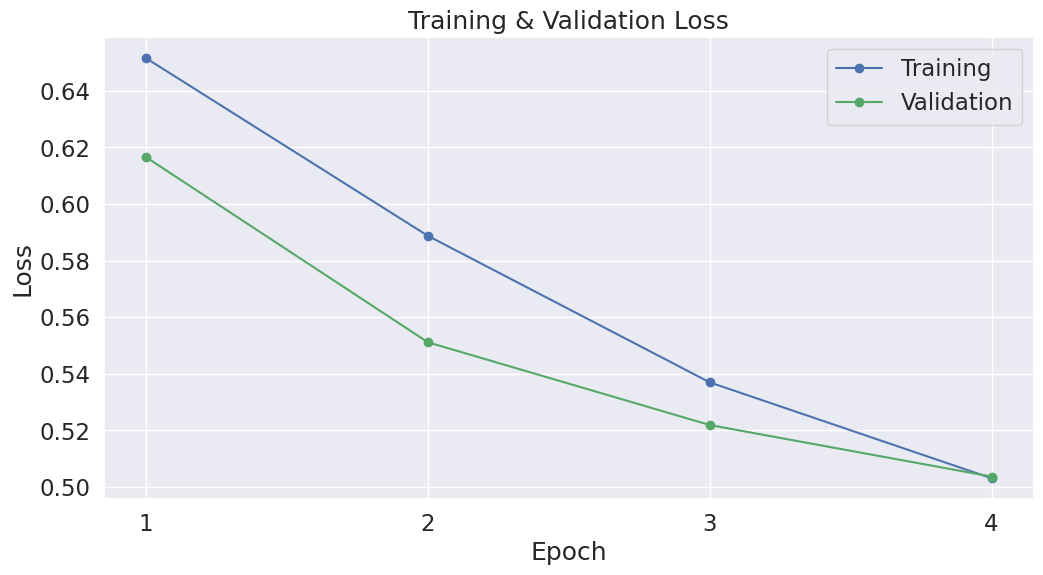

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')

# Label the plot
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# **5. Performance on Test Set**

Using Matthew's Correlation Coefficient we'll evaluate the predictions:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

We'll prepare the holdout dataset just like we did with the training data - The metric scored span from -1 to 1, and will give us an idea of how well we perform compared to the state of the art models

## **5.1. Data Perparation**

We'll need to apply all of the same steps we did for the training dataset:

In [23]:
import pandas as pd

# Load the dataset into a Pandas dataframe. This is where the data from the second/ Third language comes.
df = pd.read_csv("/content/drive/MyDrive/data/multilingual/allDataCELF.csv",  keep_default_na=False, sep = ";")
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

df.columns

Number of test sentences: 3,301



Index(['TARGET', 'RESPONSE', 'AUTO_SCORING', 'TOLD_SCORING', 'CELF_SCORING'], dtype='object')

In [24]:
# Create sentence and label lists
responses = df.RESPONSE.values
scores = df.TOLD_SCORING.values

In [25]:
# Tokenize all of the sentences and map the tokens to their word IDs
input_ids = []
attention_masks = []

# For every sentence...
for reponse in responses:
  # Encode_plus will...
  # 1) Tokenize the sentence
  # 2) Prepend the '[CLS]' token to the start.
  # 3) Append the '[SEP]' token to the send.
  # 4) Map the tokens ti their IDs.
  # 5) Pad or truncate the sentence to 'max_length'
  # 6) Create attention masks for [PAD] tokens.
  encoded_dict = tokenizer.encode_plus(
      reponse,                           # Sentence to encode.
      add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
      max_length = 44,                # Pad & truncate all sentences.--> FOR GREEK USE >44
      pad_to_max_length = True,
      return_attention_mask = True,   # Construct attn. masks.
      return_tensors = 'pt',          # Return pytorch tensors.
  )

  # Add the encoded sentence to the list.
  input_ids.append(encoded_dict['input_ids'])

  # Attention_masks differentiate relevant information from padding
  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
scores = torch.tensor(scores)

# Set the batch size
batch_size = 256

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, scores)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## **5.2. Evaluat the Test Set**

Next we can have out model generate predictions on the Test Set (the already fine-tuned model)

In [26]:
# Predicitons on the Test Set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_scores = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_scores = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  score_ids = b_scores.to('cpu').numpy()

  #remove nan from score_ids
  #score_ids = score_ids[~np.isnan(score_ids)]

  # Store predictions and true labels
  predictions.append(logits)
  true_scores.append(score_ids)

print('    DONE.')

Predicting labels for 3,301 test sentences...
    DONE.


## Matthew's Correlation Coefficient (MCC)
We'll use MCC here because the classed are imbalanced

In [27]:
print('Positive samples: %d of %d (%.2f%%)' % (df.TOLD_SCORING.sum(), len(df.TOLD_SCORING), (df.TOLD_SCORING.sum() / len(df.TOLD_SCORING)* 100.0)))

Positive samples: 1656 of 3301 (50.17%)


In [28]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating MCC for each batch...')

# For each batch...
for i in range(len(true_scores)):
    # The predictions for this batch are a 2-column ndarray (one column for "0"
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_scores_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.
    #if true_scores[i] != "nan"



    matthews = matthews_corrcoef(true_scores[i], pred_scores_i)
    matthews_set.append(matthews)

print('DONE')


Calculating MCC for each batch...
DONE


## Final Score

The final score will be based on the entire test set.

If each batch has 16 sentences in it except for the last batch which has (total%16)= x

In [29]:

# Combine all results across all batches
flat_predictions = np.concatenate(predictions, axis = 0)

# For each sample, pick the label (0 or 1) with the higher score,
flat_predictions = np.argmax(flat_predictions, axis = 1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_scores = np.concatenate(true_scores, axis = 0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_scores, flat_predictions)


print('Total MCC: %.3f' % mcc)


Total MCC: 0.581


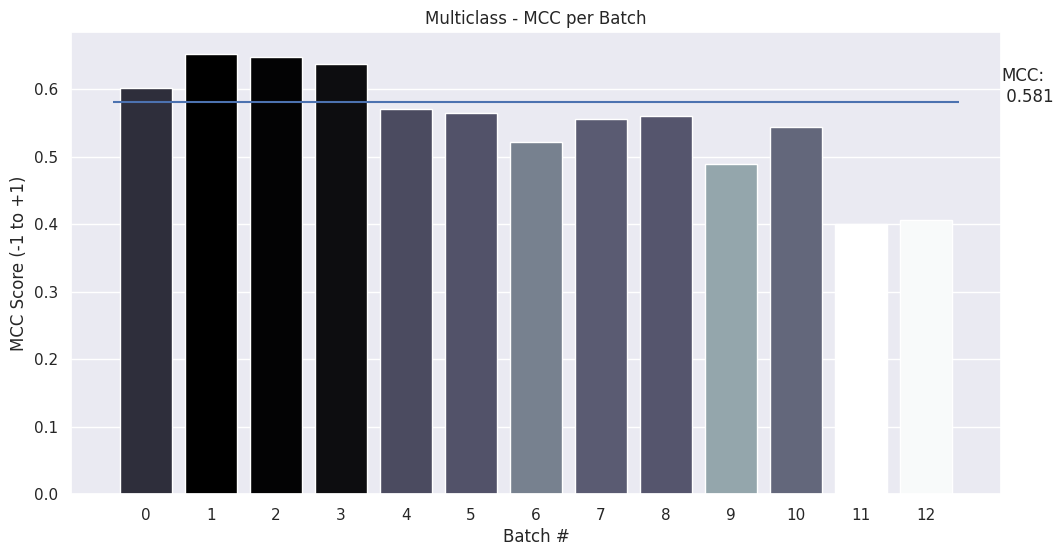

In [30]:
# Creat a barplot of the batches' MCC scores
sns.set(color_codes=True)

ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, hue = matthews_set,
#               palette="blend:#7AB,#EDA", legend=False)

#ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, hue = matthews_set,
#                 palette= "ch:start=.2,rot=-.3", legend=False)
                 palette="bone_r", legend=False)


ax.hlines(mcc, *ax.get_xlim())
ax.annotate(f'MCC:\n {mcc:.3f}', xy=(ax.get_xlim()[1],mcc))

plt.title('Multiclass - MCC per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')
#ax = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
plt.show()

Next we can combine all the results and calculate the final MCC score.

# **6. Saving the pre-trained Model**



In [31]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = input("Please enter the output directory: ")

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Please enter the output directory: Binary_Multiclass
Saving model to Binary_Multiclass


('Binary_Multiclass/tokenizer_config.json',
 'Binary_Multiclass/special_tokens_map.json',
 'Binary_Multiclass/vocab.txt',
 'Binary_Multiclass/added_tokens.json')

## **6.1 Saving the Model in Google Drive**
Idealy copy the model to Google Drive

In [32]:
'''# Copy the model files to a directory in MultiLingBERT.
!cp -r ./model_save/ "./Native2_modelSave"
'''

'# Copy the model files to a directory in MultiLingBERT.\n!cp -r ./model_save/ "./Native2_modelSave"\n'

## **6.2 Load model BACK FROM disk**



In [33]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

id2label = {0: "INCORRECT", 1:"CORRECT"}

# Load a trained model and vocabulary that you have fine-tuned
model = AutoModelForSequenceClassification.from_pretrained(output_dir, num_labels=2, id2label=id2label)

#model = model_class.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [34]:
input_texts = [
               "Who have they seen near the steps?",
               "He should wash the baby that the child is patting.",
               "What did they find yesterday in the snow?",
               "The books...",
               "The children will if they sleep.",
               "They are eating the bananas in the dark.",
               "οι οδηγοί άφησαν τους επιβάτες των λεωφορείων στην επόμενη στάση",
               "ο χορευτής πήρε την ομπρέλα του και περπάτησε στη δυνατή βροχή",
               "ο προπονητής δεν να κερδίσει η ομάδα του σήμερα",
               "η γιαγιά ότι σε αυτά τα μέρη πετούσαν περίεργα πουλιά",
               "dɔxtær-i kɛ tɔ dust dɑri xɑhærɛ mænɛ",
               "kudum kɛtɑb rɔ ɛntɛxɑb kærd?",
               "væqti lɛbæs pushidam mikhoram",
               "kahli",
               "Es war eine lange dunkle Nacht.",
               "È stata una lunga notte buia",
               "یہ ایک لمبی سیاہ رات تھی",
               "C'était une longue nuit sombre",
               "لقد كانت ليلة مظلمة طويلة",
               "أحب المدرسة"
               ]


#greek_texts = ["οι εφημερίδες γράφουν πολλά για τον ληστή που έπιασε η αστυνομία",]

for text in input_texts:
  # Encode the text
  input = tokenizer(text, truncation=True, padding="max_length", max_length=28, return_tensors="pt").to("cuda")
  with torch.no_grad():
    # Call the model to predict under the format of logits of 15 classes
    logits = model(**input).logits.cpu().detach().numpy()

  predicted_class_id = logits.argmax().item()

  prediction = model.config.id2label[predicted_class_id]

  print('The sentence: "',text, '"  is:', prediction)


The sentence: " Who have they seen near the steps? "  is: CORRECT
The sentence: " He should wash the baby that the child is patting. "  is: INCORRECT
The sentence: " What did they find yesterday in the snow? "  is: CORRECT
The sentence: " The books... "  is: INCORRECT
The sentence: " The children will if they sleep. "  is: INCORRECT
The sentence: " They are eating the bananas in the dark. "  is: CORRECT
The sentence: " οι οδηγοί άφησαν τους επιβάτες των λεωφορείων στην επόμενη στάση "  is: INCORRECT
The sentence: " ο χορευτής πήρε την ομπρέλα του και περπάτησε στη δυνατή βροχή "  is: INCORRECT
The sentence: " ο προπονητής δεν να κερδίσει η ομάδα του σήμερα "  is: CORRECT
The sentence: " η γιαγιά ότι σε αυτά τα μέρη πετούσαν περίεργα πουλιά "  is: INCORRECT
The sentence: " dɔxtær-i kɛ tɔ dust dɑri xɑhærɛ mænɛ "  is: CORRECT
The sentence: " kudum kɛtɑb rɔ ɛntɛxɑb kærd? "  is: CORRECT
The sentence: " væqti lɛbæs pushidam mikhoram "  is: INCORRECT
The sentence: " kahli "  is: INCORRECT
The